# Change in labor capacity

# TODO maybe further split into preparation and final calculation


The fraction of the total capacity lost is given by

$$
Loss = \tfrac{1}{2}(1+ERF \left( \frac{WBGT-Prod_{mean}}{Prod_{SD} * \sqrt{2}} \right))
$$

Where WBGT is WBGTmax, WBGTmean or WBGThalf.  

| Work level | $Prod_{mean}$ | $Prod_{SD}$ |
|------------|---------------|-------------|
| 200        | 35.53         | 3.94        |
| 300        | 33.49         | 3.94        |
| 400        | 32.47         | 4.16        |



In [1]:
%matplotlib inline

from pathlib import Path

import numpy as np
import scipy as sp
import pandas as pd
import geopandas as gpd
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

from numba import jit
from scipy import stats
from scipy.special import erf
# from math import erf

from tqdm import tnrange, tqdm_notebook
from config import DATA_SRC, WEATHER_SRC, POP_DATA_SRC

import population_tools

In [2]:
def labour_loss(wbgt, prod_mean, prod_sd):
    '''
    ..math:
        Loss = (1+ERF((WBGT-Prod_{mean})/(Prod_{SD} * \sqrt{2})))/2

    Args:
         WBGT is WBGTmax, WBGTmean or WBGThalf in Kelvin
         prod_mean is the mean productivity coefficient for a given power level
         prod_sd is the standard deviation coefficient for a given power level
    
    '''
    root2 = 1.4142135623730951 # np.sqrt(2)
    return (1 + erf(((wbgt - 273.15) - prod_mean) / (prod_sd * root2))) / 2



In [3]:
power_level_data = {
    200: (35.53,  3.94),
    300: (33.49, 3.94),
    400: (32.47, 4.16)
    }


MAX_YEAR = 2018
REFERENCE_YEAR_START = 1986
REFERENCE_YEAR_END = 2005

RESULTS_FOLDER = Path('./results/lancet2019/global/1.3 labour')
RESULTS_FOLDER.mkdir(exist_ok=True)

POPULATION_FILE = POP_DATA_SRC / 'population_count_2000-2020_30min_era_compat.nc'
DEMOGRAPHICS_FILE = POP_DATA_SRC / 'demographic_pct_2010_30min_era_compat.nc'

UN_DEMOGRAPHICS_FILE  = POP_DATA_SRC / 'UN' / 'WPP2017_PopulationByAgeSex_Medium.csv'
COUNTRY_SHAPEFILE = DATA_SRC / 'GIS' / 'world'/ 'ne_50m_admin_0_countries' / 'ne_50m_admin_0_countries.shp'

POP_FILE = POP_DATA_SRC / 'population_count_2000-2020_eightres.nc'

In [4]:
WBGT_FOLDER = DATA_SRC / 'lancet' / 'wbgt'

## Plot the labour capacity function

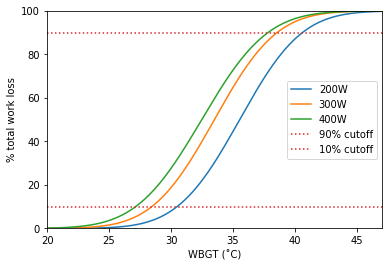

In [5]:
_wbgt = np.arange(20, 47, 0.1) + 273.15
labourcapacity = labour_loss(_wbgt, 35.53, 3.94)
plt.plot(_wbgt - 273.15, labourcapacity * 100, label='200W', color='C0')

labourcapacity = labour_loss(_wbgt, 33.49, 3.94)
plt.plot(_wbgt- 273.15, labourcapacity* 100, label='300W', color='C1')
                             
labourcapacity = labour_loss(_wbgt, 32.47, 4.16)
plt.plot(_wbgt- 273.15, labourcapacity* 100, label='400W', color='C2')

plt.axhline(90, label='90% cutoff', color='C3', linestyle=':')
plt.axhline(10, label='10% cutoff', color='C3', linestyle=':')

plt.legend()


plt.ylim(0, 100)
plt.xlim(20, 47)

plt.xlabel('WBGT (˚C)')
plt.ylabel('% total work loss')

plt.savefig(RESULTS_FOLDER / 'labour_loss_function.png', dpi=300)
plt.savefig(RESULTS_FOLDER / 'labour_loss_function.pdf')

### Plot the clipped version

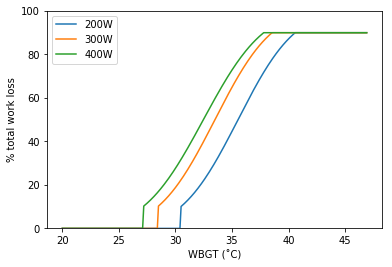

In [5]:
def _clip(lc):
    lc = xr.where(lc < 0.1, 0, lc)
    lc = xr.where(lc > 0.9, 0.9, lc)
    return lc

_wbgt = np.arange(20, 47, 0.1) + 273.15

labourcapacity = labour_loss(_wbgt, 35.53, 3.94)
labourcapacity = _clip(labourcapacity)

plt.plot(_wbgt - 273.15, labourcapacity * 100, label='200W')

labourcapacity = labour_loss(_wbgt, 33.49, 3.94)
labourcapacity = _clip(labourcapacity)
plt.plot(_wbgt- 273.15, labourcapacity* 100, label='300W')

labourcapacity = labour_loss(_wbgt, 32.47, 4.16)
labourcapacity = _clip(labourcapacity)
plt.plot(_wbgt- 273.15, labourcapacity* 100, label='400W')
plt.xlabel('WBGT (˚C)')
plt.ylabel('% total work loss')
plt.ylim(0, 100)
plt.legend()

plt.savefig(RESULTS_FOLDER / 'labour_loss_function_clip.png', dpi=300)

## Apply to WBGT mean, max, half

In [8]:
wbgt_mean = xr.open_mfdataset(
    str(WBGT_FOLDER / 'daily_wbgtmean'/ 'wbgt_mean_*.nc'),
    chunks={'time':100}
                             )
wbgt_max = xr.open_mfdataset(
    str(WBGT_FOLDER/ 'daily_wbgtmax'/ 'wbgt_max_*.nc'),
    chunks={'time':100}
)

wbgt_half = xr.open_mfdataset(
    str(WBGT_FOLDER / 'daily_wbgthalf'/ 'wbgt_half_*.nc'),
    chunks={'time':100}
)

In [9]:
def hours_capacity_loss_ufunc(wbgt_mean, wbgt_max, wbgt_half, power_level):
    """
    model hourly WBGT using the 4+4+4 method giving a close approximation 
    to the hourly WBGT during the day. 4 hours per day at WBGTmax, 4 hours 
    at WBGThalf, and 4 hours at WBGTmean.
    
    2 extra conditions:  
    as people take micro-breaks during the hour we assume any work hours
    lost less than 10% is no work hours lost, and as everyone can do at 
    least 6 minutes/hour work even under extreme conditions, we assume 90% 
    work hours lost is a maximum.
    
    """
    power_level_data = {
        200: (35.53,  3.94),
        300: (33.49, 3.94),
        400: (32.47, 4.16)
        }
    
    prod_mean, prod_sd = power_level_data[float(power_level)]
    
    
    # Calculate the labour loss and clip it to the 10%/90%
    # thresholds
    loss_mean = labour_loss(wbgt_mean, prod_mean, prod_sd)
    loss_mean = xr.where(loss_mean < 0.1, 0, loss_mean)
    loss_mean = xr.where(loss_mean > 0.9, 0.9,  loss_mean)
    
    
    loss_max = labour_loss(wbgt_max, prod_mean, prod_sd)
    loss_max = xr.where(loss_max < 0.1, 0, loss_max)
    loss_max = xr.where(loss_max > 0.9, 0.9, loss_max)
    
    
    loss_half = labour_loss(wbgt_half, prod_mean, prod_sd)
    loss_half = xr.where(loss_half < 0.1, 0, loss_half)
    loss_half = xr.where(loss_half > 0.9, 0.9, loss_half)
    
    loss_hours = 4 * loss_mean + 4 * loss_max + 4 * loss_half
    return loss_hours


def save_loss_hours_for_power(power_level):
    loss_hours = xr.apply_ufunc(hours_capacity_loss_ufunc,
                     wbgt_mean.wbgt, wbgt_max.wbgt, wbgt_half.wbgt, power_level,
                     output_dtypes=[np.dtype(wbgt_mean.wbgt)],
                     dask='parallelized'
                    )

    loss_hours.name = 'loss_hours'
    loss_hours = loss_hours.resample(time='1M').sum(dim='time')
    loss_hours = loss_hours.to_dataset()
    years, datasets = zip(*loss_hours.groupby('time.year'))
    paths = [DATA_SRC / 'lancet' / 'labour_capacity' / f'monthly_labour_loss_hours_{power_level}'/ f'loss_hours_{y}.nc' for y in years]
    xr.save_mfdataset(datasets, paths)
        

In [10]:
power_level = 200

save_loss_hours_for_power(power_level)

/home/jonathanchambers/Scratch/.conda/envs/lancet/lib/python3.7/site-packages/dask/array/blockwise.py:204: UserWarning: The da.atop function has moved to da.blockwise
  warnings.warn("The da.atop function has moved to da.blockwise")


In [ ]:
power_level = 300

save_loss_hours_for_power(power_level)

/home/jonathanchambers/Scratch/.conda/envs/lancet/lib/python3.7/site-packages/dask/array/blockwise.py:204: UserWarning: The da.atop function has moved to da.blockwise
  warnings.warn("The da.atop function has moved to da.blockwise")


In [ ]:
power_level = 400

save_loss_hours_for_power(power_level)

# Calculate a baseline loss hours

For sharing

In [5]:
hours_lost_200 = xr.open_mfdataset(str(DATA_SRC / 'lancet' / 'labour_capacity'/ 'monthly_labour_loss_hours_200' / 'loss_hours_*.nc'))
hours_lost_300 = xr.open_mfdataset(str(DATA_SRC / 'lancet'/ 'labour_capacity' / 'monthly_labour_loss_hours_300' / 'loss_hours_*.nc'))
hours_lost_400 = xr.open_mfdataset(str(DATA_SRC / 'lancet'/ 'labour_capacity' / 'monthly_labour_loss_hours_400' / 'loss_hours_*.nc'))

# Calculate the yearly total hours lost for each power level
hours_lost_200 = hours_lost_200.groupby('time.year').sum(dim='time')
hours_lost_300 = hours_lost_300.groupby('time.year').sum(dim='time')
hours_lost_400 = hours_lost_400.groupby('time.year').sum(dim='time')

In [6]:
hours_lost = xr.concat([hours_lost_200, hours_lost_300, hours_lost_400], dim=pd.Index( [200, 300, 400], name='activity_level'))

In [7]:
loss_hours_reference = hours_lost.sel(year=slice(REFERENCE_YEAR_START,REFERENCE_YEAR_END)).mean(dim='year')


In [30]:
powers, datasets = zip(*loss_hours_reference.groupby('activity_level'))
paths = [DATA_SRC / 'lancet' / 'labour_capacity' / f'loss_hours_mean_{REFERENCE_YEAR_START}-{REFERENCE_YEAR_END}_{power_level}.nc' for power_level in powers]
xr.save_mfdataset(datasets, paths)

In [9]:
# Over-complicated way of saving back to single files per power >_<
y = 2000
powers, datasets = zip(*hours_lost.sel(year=y).groupby('activity_level'))
paths = [DATA_SRC / 'lancet' / 'labour_capacity' / f'loss_hours_{y}_{power_level}.nc' for power_level in powers]
xr.save_mfdataset(datasets, paths)

In [10]:
# Over-complicated way of saving back to single files per power >_<
y = 2010
powers, datasets = zip(*hours_lost.sel(year=y).groupby('activity_level'))
paths = [DATA_SRC / 'lancet' / 'labour_capacity' / f'loss_hours_{y}_{power_level}.nc' for power_level in powers]
xr.save_mfdataset(datasets, paths)

In [11]:
# Over-complicated way of saving back to single files per power >_<
y = 2018
powers, datasets = zip(*hours_lost.sel(year=y).groupby('activity_level'))
paths = [DATA_SRC / 'lancet' / 'labour_capacity' / f'loss_hours_{y}_{power_level}.nc' for power_level in powers]
xr.save_mfdataset(datasets, paths)

# Apply the shares of worker activity (OLD, SUPERCEDED)

In [6]:
UN_DEMOGRAPHICS_TABLE = pd.read_csv(UN_DEMOGRAPHICS_FILE)
# Add the percentages from the population totals
UN_DEMOGRAPHICS_TABLE['PopPct'] = UN_DEMOGRAPHICS_TABLE.groupby(['LocID','Time']).PopTotal.apply(lambda g: g/g.sum())

In [7]:
# Load a country shapefile for rasterising
COUNTRIES = gpd.read_file(str(COUNTRY_SHAPEFILE))
# Translate to match raster coordinates
COUNTRIES.geometry = COUNTRIES.translate(xoff=180)

# Remove missing UN A3 code fields, convert to int and set as index
COUNTRIES.loc[COUNTRIES.un_a3 == '-099', 'un_a3'] = np.nan
COUNTRIES.un_a3 = COUNTRIES.un_a3.astype(float)
COUNTRIES = COUNTRIES[np.isfinite(COUNTRIES.un_a3)]
COUNTRIES.un_a3 = COUNTRIES.un_a3.astype(int)
COUNTRIES = COUNTRIES.set_index('un_a3')

In [8]:
agri = pd.read_excel(DATA_SRC / 'lancet' / 'PopulationERADave.xlsx', 
                     sheet_name='Country-Agemp-to-pop ratio', index_col=0)

indu = pd.read_excel(DATA_SRC / 'lancet' / 'PopulationERADave.xlsx', 
                     sheet_name='Country-Indemp-to-pop ratio', index_col=0)

serv = pd.read_excel(DATA_SRC / 'lancet' / 'PopulationERADave.xlsx', 
                     sheet_name='Country-Servemp-to-pop ratio', index_col=0)

In [9]:
# Tidy up the table and convert the date columns to numbers
agri = agri.drop('Economic activity', axis='columns')
agri.columns = agri.columns.astype(int)

indu = indu.drop('Economic activity', axis='columns')
indu.columns = indu.columns.astype(int)

serv = serv.drop('Economic activity', axis='columns')
serv.columns = serv.columns.astype(int)

In [10]:
# Add country data to sector tables
c = COUNTRIES[['iso_a3', 'iso_n3', 'geometry']]
c = c.reset_index().set_index('iso_a3')

agri = agri.join(c)
indu = indu.join(c)
serv = serv.join(c)

In [47]:
agri[2018] = agri[2017] + (agri[[2015, 2016, 2017]].values - agri[[2014, 2015, 2016]].values).mean(axis=1)
indu[2018] = indu[2017] + (indu[[2015, 2016, 2017]].values - indu[[2014, 2015, 2016]].values).mean(axis=1)
serv[2018] = serv[2017] + (serv[[2015, 2016, 2017]].values - serv[[2014, 2015, 2016]].values).mean(axis=1)